In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
ROOTPATH = '/home/teguh/git/publications/ram2020/figures'

In [55]:
data_rtsp = np.load('data/rivet_planning_cylindrical_rtsp.npy', allow_pickle=True)[()]
data_baseline = np.load('data/rivet_planning_cylindrical_baseline.npy', allow_pickle=True)[()]

rtsp_fixed_dists, rtsp_fixed_disps, rtsp_fixed_trajs, rtsp_fixed_config_time,rtsp_fixed_plan_time, rtsp_fixed_postplan_time  = data_rtsp['rtsp_fixed']
selmax_dists, selmax_disps, selmax_trajs,  selmax_config_time, selmax_plan_time, selmax_postplan_time  = data_baseline['rtsp_fixed']
num_configs = data_rtsp['num_configs']

In [59]:
fontsize = 16
legendfontsize = 12
figsize = (6,4)

tosave = True

## Plot 1: num_configs against traj length

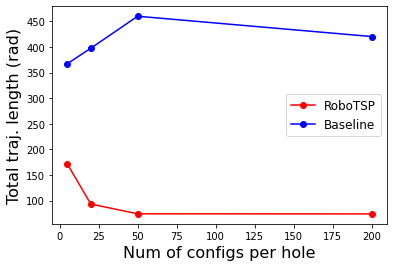

In [60]:
plt.figure(figsize=figsize)
plt.plot(list(rtsp_fixed_dists.keys()), list(rtsp_fixed_dists.values()), 'o-r', label='RoboTSP')
plt.plot(list(selmax_dists.keys()), list(selmax_dists.values()), 'o-b', label='Baseline')
#plt.plot(list(selrandom_dists.keys()), list(selrandom_dists.values()), 'o-g', label='random')
plt.legend(fontsize = legendfontsize)
plt.xlabel('Num of configs per hole', fontsize = fontsize)
plt.ylabel('Total traj. length (rad)', fontsize = fontsize)
#plt.title("Trajectory length comparison", fontsize = fontsize)
if tosave: plt.savefig(ROOTPATH + '/traj_length.png',bbox_inches='tight', pad_inches=0, dpi=500)
plt.show()

In [61]:
selmax_dists[200]/rtsp_fixed_dists[200]

5.674483332065258

## Plot 2: num_configs against disp

In [65]:
num_holes = [64]

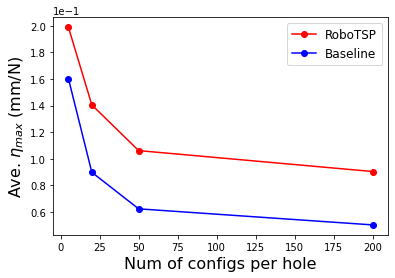

In [66]:
plt.figure(figsize=figsize)
plt.plot(list(rtsp_fixed_disps.keys()), np.array(list(rtsp_fixed_disps.values()))/num_holes[0], 'o-r', label='RoboTSP')
plt.plot(list(selmax_disps.keys()), np.array(list(selmax_disps.values()))/num_holes[0], 'o-b', label='Baseline')
plt.legend(fontsize = legendfontsize)
plt.xlabel('Num of configs per hole', fontsize = fontsize)
plt.ylabel(r'Ave. $\eta_{max}$ (mm)', fontsize = fontsize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.title("End-effector displacement comparison", fontsize = fontsize)
if tosave: plt.savefig(ROOTPATH + '/disp.png',bbox_inches='tight', pad_inches=0, dpi=500)
plt.show()

## Plot 3: num_configs against planning time

In [67]:
rtsp_total_time = np.array(rtsp_fixed_config_time) + np.array(rtsp_fixed_plan_time) + np.array(rtsp_fixed_postplan_time)
selmax_total_time = np.array(selmax_config_time) + np.array(selmax_plan_time) + np.array(selmax_postplan_time)

In [68]:
num_configs

[5, 20, 50, 200]

In [72]:
indices = [0, 1, 2, 3]

In [73]:
num_configs_selected = num_configs

In [78]:
rtsp_fixed_config_time = np.array(rtsp_fixed_config_time)
rtsp_fixed_plan_time = np.array(rtsp_fixed_plan_time)
rtsp_fixed_postplan_time = np.array(rtsp_fixed_postplan_time)
selmax_config_time = np.array(selmax_config_time)
selmax_plan_time = np.array(selmax_plan_time)
selmax_postplan_time = np.array(selmax_postplan_time)

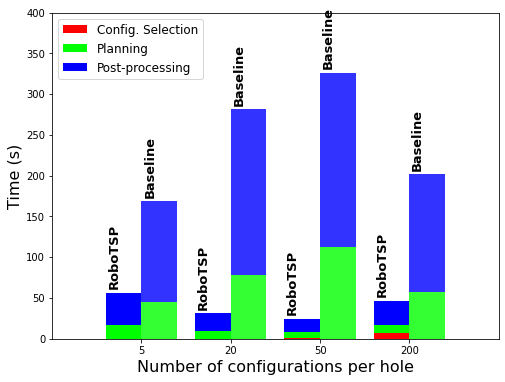

In [84]:
width = .4
plt.figure(figsize = (8,6))
bar1 = plt.bar(np.arange(len(indices))-width/2, rtsp_fixed_config_time[indices], width = width, color=(1,0,0,1), label='Config. Selection')
bar2 = plt.bar(np.arange(len(indices))-width/2, rtsp_fixed_plan_time[indices], bottom=rtsp_fixed_config_time[indices], width = width,color=(0,1,0,1), label='Planning')
bar3 = plt.bar(np.arange(len(indices))-width/2, rtsp_fixed_postplan_time[indices], bottom=np.array(rtsp_fixed_config_time[indices])+np.array(rtsp_fixed_plan_time[indices]), width = width, color=(0,0,1,1), label='Post-processing')

bar4 = plt.bar(np.arange(len(indices))+width/2, selmax_config_time[indices], width = width, color=(1,0,0,.8))
bar5 = plt.bar(np.arange(len(indices))+width/2, selmax_plan_time[indices], bottom=selmax_config_time[indices], width = width, color=(0,1,0,.8))
bar6 = plt.bar(np.arange(len(indices))+width/2, selmax_postplan_time[indices], bottom=np.array(selmax_config_time[indices])+np.array(selmax_plan_time[indices]), width = width, color=(0,0,1,.8))

for i, idx in enumerate(indices):
    plt.text(bar1[i].get_x() + 0.02, rtsp_total_time[idx] + 8,'RoboTSP', rotation=90, fontsize = fontsize-3, weight = 'bold')
    plt.text(bar1[i].get_x() + width + 0.02, selmax_total_time[idx] + 8,'Baseline', rotation=90, fontsize = fontsize-3, weight = 'bold')

plt.xticks(np.arange(len(indices)), num_configs_selected)

plt.legend(fontsize = legendfontsize)
#plt.title('Breakdown of the computation time', fontsize = fontsize)
plt.ylabel('Time (s)', fontsize=fontsize)
plt.xlabel('Number of configurations per hole', fontsize = fontsize)
plt.axis([-1,4,0,400])
plt.savefig(ROOTPATH + '/comp_time_rtsp.png',bbox_inches='tight', pad_inches=0, dpi=500)
plt.show()

# Visualize the trajectories

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
import os

import scipy
import matplotlib

from robot import *
from utils import *
import pybullet as p
import pybullet_data
import networkx as nx
from functools import partial

%load_ext autoreload
%autoreload 2

## Setup Pybullet

In [2]:
# name_in =  'urdf/support.obj'
# name_out = 'urdf/support_concave.obj'
# name_in =  'urdf/support_cylindrical_col.obj'
# name_out = 'urdf/support_cylindrical_colconc.obj'
# name_log = "log.txt"
# p.vhacd(name_in, name_out, name_log, alpha=0.04,resolution=1000000 )

Now 'urdf/support_cylindrical.urdf' shows the structure real visualization but with the collision shape constructed from the command p.vhacd(.)

In [3]:
physics_client_id = p.connect(p.GUI)
p.setPhysicsEngineParameter(enableFileCaching=0)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI,0)


In [4]:
p.resetSimulation()

### Setup Robot

In [5]:
robot_urdf = 'urdf/panda/panda_arm_rivet.urdf';
robot_id = p.loadURDF(fileName=robot_urdf)
dof = p.getNumJoints(robot_id)

plane_id = p.loadURDF('plane.urdf')
pb_joint_indices = np.arange(7)
joint_limits = get_joint_limits(robot_id, pb_joint_indices)


set_q_std = partial(set_q,robot_id, pb_joint_indices)
vis_traj_std = partial(vis_traj, vis_func= set_q_std)

### Visualize the big frame

In [6]:
is_simple = False
obs_ids = []
rgbacolor = (0,0,1,0)

board_id = p.loadURDF('urdf/support_cylindrical.urdf', globalScaling=0.0008, useFixedBase=1)
quat = w2quat(np.array([0,0,-np.pi/2]))
p.resetBasePositionAndOrientation(board_id, (0.6,-2.2,-.3), quat)

offset = 0.

In [7]:
x_board = 0.47
p.resetBasePositionAndOrientation(board_id, (x_board,-1.7,-.41), quat)

### Setup targets in the middle

In [8]:
ys = np.concatenate([np.arange(-0.34, -0.15, 0.05), np.arange(0.2, 0.36, 0.05)],-1)
zs = np.arange(0.35, 0.54, 0.05) + 0.2
x = x_board + 0.3
targets_mid = []
target_ids = []
offset = -0.05
for y in ys:
    for z in zs:
        target = np.array([x, y,z])
        targets_mid += [target]
        _,_,target_id = create_primitives(p.GEOM_BOX, halfExtents=(0.03, 0.01, 0.01), rgbaColor=(1,0,0,1), baseMass=0)
        target_ids += [target_id]
        p.resetBasePositionAndOrientation(target_id, targets_mid[-1], (0,0,0,1))
        targets_mid[-1][0] -= 0.03

targets_mid = np.array(targets_mid)

### Targets on the bottom

In [9]:
R = w2mat(quat2w(euler2quat([0,10,0.])))

zs = np.arange(0.25,0.31, 0.05) + 0.2
#ys = np.array([-0.45, -0.25,  0.15,  0.35])
#zs = np.arange(0.6, 0.81, 0.1)
x = x_board + 0.25
targets_down = []
target_ids = []
offset = 0.03
for y in ys:
    offset_x = 0.
    for z in zs:
        target = np.array([x+offset_x, y,z])
        targets_down += [target]
        _,_,target_id = create_primitives(p.GEOM_BOX, halfExtents=(0.03, 0.01, 0.01), rgbaColor=(0,0,1,1), baseMass=0)
        target_ids += [target_id]
        p.resetBasePositionAndOrientation(target_id, targets_down[-1], (0,0,0,1))
        targets_down[-1] += (R@np.array([1,0,0]))*offset
        offset_x += 0.03

targets_down = np.array(targets_down)

for target_id in target_ids:
    p.resetBasePositionAndOrientation(target_id,posObj=p.getBasePositionAndOrientation(target_id)[0 ], ornObj=euler2quat([0,10,0.]).tolist())

### Targets on the top

In [10]:
R = w2mat(quat2w(euler2quat([0,-10,0.])))

zs = np.arange(0.55,0.61, 0.05) + 0.2

x = x_board + 0.27
targets_up = []
target_ids = []
offset = 0.03
for y in ys:
    offset_x = 0.
    for z in zs:
        target = np.array([x+offset_x, y,z])
        targets_up += [target]
        _,_,target_id = create_primitives(p.GEOM_BOX, halfExtents=(0.03, 0.01, 0.01), rgbaColor=(0,1,0,1), baseMass=0)
        target_ids += [target_id]
        p.resetBasePositionAndOrientation(target_id, targets_up[-1], (0,0,0,1))
        targets_up[-1] += (R@np.array([1,0,0]))*offset
        offset_x -= 0.03

targets_up = np.array(targets_up)

for target_id in target_ids:
    p.resetBasePositionAndOrientation(target_id,posObj=p.getBasePositionAndOrientation(target_id)[0], ornObj=euler2quat([0,-10,0.]).tolist())

In [30]:
data = np.load('data/rivet_planning_cylindrical_computeweight.npy', allow_pickle=True)[()]

In [31]:
rtsp_fixed_dists, rtsp_fixed_disps, rtsp_fixed_trajs = data['rtsp_fixed'] 
#ws = data['ws']

In [23]:
data = np.load('data/rivet_planning_cylindrical_rtsp.npy', allow_pickle=True)[()]

In [25]:
rtsp_fixed_dists, rtsp_fixed_disps, rtsp_fixed_trajs, rtsp_fixed_config_time,rtsp_fixed_plan_time, rtsp_fixed_postplan_time = data['rtsp_fixed'] 
#ws = data['ws']

In [52]:
p.resetDebugVisualizerCamera(cameraDistance=2, cameraYaw=-70, 
                             cameraPitch= -30, cameraTargetPosition=np.array([1,0,0]))


In [53]:
for i,traj in enumerate(rtsp_fixed_trajs[10]):
    if i == 31:
        for j in range(64):
            p.resetDebugVisualizerCamera(cameraDistance=2, cameraYaw=-70 - j*40./64, 
                             cameraPitch= -30, cameraTargetPosition=np.array([1,0,0]))        
            time.sleep(0.01)
    vis_traj_std(traj,dt=0.04)


In [41]:
p.resetDebugVisualizerCamera(cameraDistance=2, cameraYaw=-110, 
                             cameraPitch= -30, cameraTargetPosition=np.array([1,0,0]))

In [42]:
for i in range(64):
    time.sleep(0.1)